# Lab Course: Distributed Data Analytics Exercise Sheet 5
**Submitted by: Mohit Bansal**

**Student ID: 279314**

### Exercise 1A: (7 points)

Stationarity of a time series dataset is an important assumption https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm 

Following are the two time series datasets.
* daily temperature: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-au!ds=2324&display=line
* air passengers: https://www.kaggle.com/rakannimer/air-passengers/data

Your tasks are (write python code and show with plots the following):
* Check if the two datasets fulfill the stationary assumptions? Ideally you should write a function name stationary check and pass in a time series. This function should plot original series, rolling average and rolling std.

* If one of the datasets do not fulfill the stationary assumption can you use smoothing technique i.e. taking rolling average to make it stationary?

### Solution:

First, let's import the data into time series format using pandas. Remember, sometimes data might contain '?' characters which may cause trouble while plotting time series. Please make sure and remove those first.

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 22 11:25:44 2018

@author: mundanemohit
"""

from pandas import read_csv
import os
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import numpy

path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex05/'
os.chdir(path)

# Reading first dataset
df = read_csv('daily-minimum-temperatures-in-me.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, dtype = 'a')
df = df.astype(float)

# Reading second dataset
df2 = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, dtype = 'a')
df2 = df2.astype(float)

/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now, let's design the stationary check function. It will take 2 arguments i.e. time series and the size of the moving window. It will print the time series with the rolling mean and standard deviation on the same chart for visual analysis.

In [15]:
def stationary_check(data,window=3):
    # Get rolling mean
    data_rm = data.rolling(window=window).mean()
    # Get rolling standard deviation
    data_std = data.rolling(window=window).std()
    data.plot()
    data_rm.plot()
    data_std.plot()

Let's see the result for dataset 1.

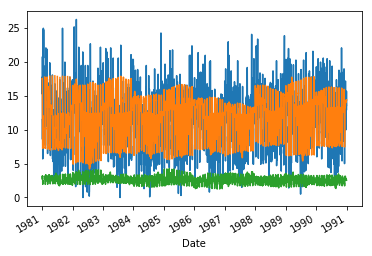

In [16]:
stationary_check(df, 30)

#### Comments:

* The given time series contains 10 years of daily temperature data from 1981 to 1991
* We have taken 30-day rolling window for evaluation
* As you can see, there's already some seasonality in the dataset (Sinusoidal wave)
* The standard deviation (green) is more or less constant. This is because temperature doesn't vary much from day to day in a short span
* The rolling mean however, like the dataset is a sinusoidal wave. This is an effect of seasonality

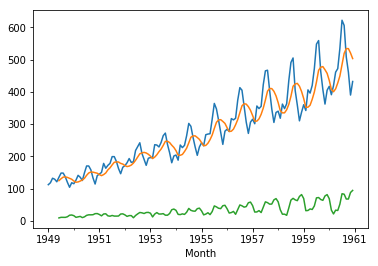

In [17]:
stationary_check(df2, 6)

#### Comments:

* This is a dataset containing 12 years of data about monthly average Air passengers for a flight
* Here, we can see an upwards trend along with seasonality. This upwards trend was not present in the previous dataset
* We have taken 6 month rolling window for this 
* As we can see, this dataset is not stationary either
* The standard deviation increases and also destablizes as we move forward in time
* The rolling average follows the trend and the seasonality

Both of these datasets can be made stationary by:

1. **Removing trend (detrending)** - We can fit a trendline to the dataset and subtract it from the data. It can then be added back to the final prediction
2. **Removing seasonality (data differencing)** - Difference can be calculated between every period or season to create new transformed dataset

### Exercise 1B: (8 points)

In this task you will forecast using ARIMA model. You can use the datasets given above. 
Your tasks are (write python code and show with plots the following):

+ Write a python code that builds an ARIMA model.
+ Split the data into train and validation. The time series data is usually split on the time not
randomly.
+ Train the ARIMA model.
+ use validation dataset to check the validation accuracy.

### Solution:

+ In order for the prediction to be more accurate, we need to difference the data to remove seasonality.
+ So, we create a difference function which takes the dataset and seasonality interval as an argument
+ But, in order to make the prediction results meaningful, we need to inverse the difference operation
+ We will use the inverse difference function, which calculates the scaled value for each prediction 

In [18]:
# Differenced dataset
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

** MY ARIMA:**
+ **data:** Input data
+ **ar:** Time lags for Auto regression
+ **i:** Number of times data has been differenced previously
+ **ma:** Order of Moving Average
+ **diff:** Seasonality term for differencing

**STEPS:**

1. Difference data
2. Divide into train and test sets
3. Train the ARIMA with training set
4. Forecast values
5. Convert forecasted values into predictions by performing inverse differentiation
6. Compare with actual results
7. Plot the results

In [22]:
def my_Arima(data, ar, i, ma, diff):    
    # Create differenced dataset
    diff_df = difference(data, diff)
    size = int(len(diff_df) * 0.80)

    # Training and testing set
    train, test = diff_df[0:size], diff_df[size:len(diff_df)]

    # Model building using training set
    ARIMA_mod = ARIMA(train, order=(ar, i, ma))
    mod_fit = ARIMA_mod.fit(disp=0)    
    #prediction = mod_fit.predict(start=len(train)-1,  end = len(data)-1)

    # Prediction on test set
    forecast = mod_fit.forecast(steps=len(data)-size)[0]
    
    # Convert back to inverse
    history = [x for x in train]
    day = 1
    prediction = list()
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, diff)
        history.append(inverted)
        prediction.append(inverted)
        day += 1    
    error = mean_squared_error(data[size:len(data)].values, prediction)
    print('Test MSE: %.3f' % error)
    # plot
    pyplot.plot(data[size:len(data)].values, label = 'Actuals')
    pyplot.plot(prediction, color='red', label = 'Predicted')
    pyplot.legend(['Actuals', 'Predicted'])
    pyplot.show()

Test MSE: 49.252


/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


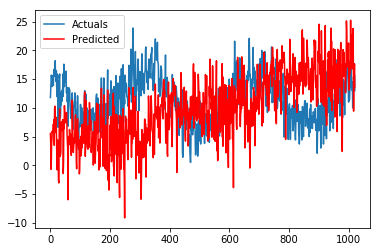

In [23]:
my_Arima(df, 2,1,0, diff = 365)

/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/mundanemohit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Test MSE: 34150.542


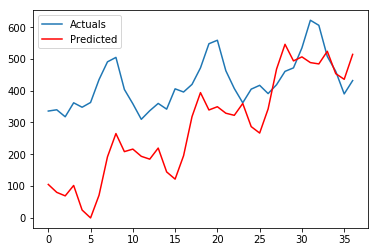

In [24]:
my_Arima(df2, 2,2,2, diff = 10)

$P^T_{1,2} = \frac{N_1^T - N_2^T}{N_1^T + N_2^T}$


### Excercise 2: (5 Points)

In this exercise, let apply your logistic regression model on an image dataset, the Olivetti faces dataset.

1. Load the Olivetti faces dataset, randomly split it into training set 90% and test set 10%.
2. Define a learning model using cross entropy cost function. Explain how you come up with the learning model.
3. Train the model on the training set and make prediction on the test set.
4. Report and plot accuracy on both training set and test set.
5. Create a Tensorboard that presents basic information such as scalars, graphs, distributions and histograms. You might check your Tensorboard at localhost:6006.


### Solution:

* We used tensorflow to create a gradient descent based model with softmax cross entropy function
* Data is divided 90-10% into train and test sets
* Model trained on training set to make predictions


In [29]:
import tensorflow as tf
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd

# Load olivetti dataset
faces_df = fetch_olivetti_faces()
x_train, x_test, y_train, y_test = train_test_split(
        faces_df.data, faces_df.target, test_size=0.10, random_state=0)

alpha = 0.01        #Learning rate
epochs = 30         
batch_size = 360
step = 5

# Define mini batch 
x = tf.placeholder(tf.float32, [batch_size, 4096]) 
y = tf.placeholder(tf.float32, [batch_size,40]) 

# Set initial weight and bias
Weights = tf.Variable(tf.zeros([4096, 40]))
Bias = tf.Variable(tf.zeros([40]))
logits =tf.matmul(x , Weights) + Bias

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= y)
loss = tf.reduce_mean(entropy)
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    avg_cost = 0
    
    print ('Processing loss values:')
    for epoch in range(epochs):
        for i in range(100):
            indices = np.random.choice(360, batch_size)   
            _, c = sess.run([optimizer, loss], feed_dict={x: x_train,
                                                          y: pd.get_dummies(y_train)})
        if (epoch+1) % step == 0:
            print("Epoch:", '%d' % (epoch+1), "cost=", "{:.9f}".format(c))

Processing loss values:
Epoch: 5 cost= 1.412648559
Epoch: 10 cost= 0.716404378
Epoch: 15 cost= 0.446662903
Epoch: 20 cost= 0.313983113
Epoch: 25 cost= 0.237933666
Epoch: 30 cost= 0.189660370
